In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [39]:
# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

In [40]:
# Load the UCI Heart Disease dataset
# Note: You might need to adjust the URL or path based on where you have the dataset
print("Loading UCI Heart Disease dataset...")
try:
    # Try standard UCI heart disease file format
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
    column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 
                    'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
    df = pd.read_csv(url, names=column_names)
except:
    try:
        # Try alternative format (Kaggle version)
        df = pd.read_csv('C:\Course\Heart Disease UCI Dataset\DATA\heart_disease_uci.csv')
        print("Loaded dataset from 'heart_disease_uci.csv'")
    except:
        print("Error loading dataset. Please ensure the dataset file is available.")
        print("You may need to download it from: https://www.kaggle.com/ronitf/heart-disease-uci")
        exit()

Loading UCI Heart Disease dataset...
Loaded dataset from 'heart_disease_uci.csv'


In [99]:
# Display basic information about the dataset
print("--- Dataset Information ---")
print(f"Dataset shape: {df.shape}")
print("\nFirst 10 rows:")
print(df.head(10))
print("\n\n\n Last 10 rows:")
print(df.tail(10))

--- Dataset Information ---
Dataset shape: (920, 16)

First 10 rows:
   id  age  sex  dataset  cp  trestbps   chol  fbs  restecg  thalch  exang  \
0   1   63  NaN      NaN NaN     145.0  233.0  1.0      NaN   150.0    0.0   
1   2   67  NaN      NaN NaN     160.0  286.0  0.0      NaN   108.0    1.0   
2   3   67  NaN      NaN NaN     120.0  229.0  0.0      NaN   129.0    1.0   
3   4   37  NaN      NaN NaN     130.0  250.0  0.0      NaN   187.0    0.0   
4   5   41  NaN      NaN NaN     130.0  204.0  0.0      NaN   172.0    0.0   
5   6   56  NaN      NaN NaN     120.0  236.0  0.0      NaN   178.0    0.0   
6   7   62  NaN      NaN NaN     140.0  268.0  0.0      NaN   160.0    0.0   
7   8   57  NaN      NaN NaN     120.0  354.0  0.0      NaN   163.0    1.0   
8   9   63  NaN      NaN NaN     130.0  254.0  0.0      NaN   147.0    0.0   
9  10   53  NaN      NaN NaN     140.0  203.0  1.0      NaN   155.0    1.0   

   oldpeak  slope   ca  thal  num  
0      2.3    NaN  0.0   NaN    0  


In [100]:
# Check for missing values
print("Checking for missing values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found")

Checking for missing values:
sex        920
dataset    920
cp         920
restecg    920
slope      920
thal       920
dtype: int64


In [97]:
# Handle any '?' values which might be present in some versions of the dataset
for column in df.columns:
    if df[column].dtype == object:
        df[column] = pd.to_numeric(df[column], errors='coerce')

In [98]:
# Handle any remaining missing values (if any)
if df.isnull().sum().sum() > 0:
    print("Replacing missing values with median for numerical columns")
    for col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)

Replacing missing values with median for numerical columns


In [104]:
# Ensure target is binary (some versions have multiple classes)
if df['num'].nunique() > 2:
    print("Converting target to binary classification task")
    # If target has values > 1, convert to binary (0: no disease, 1: disease)
    df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

In [103]:
# Exploratory Data Analysis
print("--- Exploratory Data Analysis ---")

--- Exploratory Data Analysis ---


Target distribution: No Disease: 411, Disease: 509


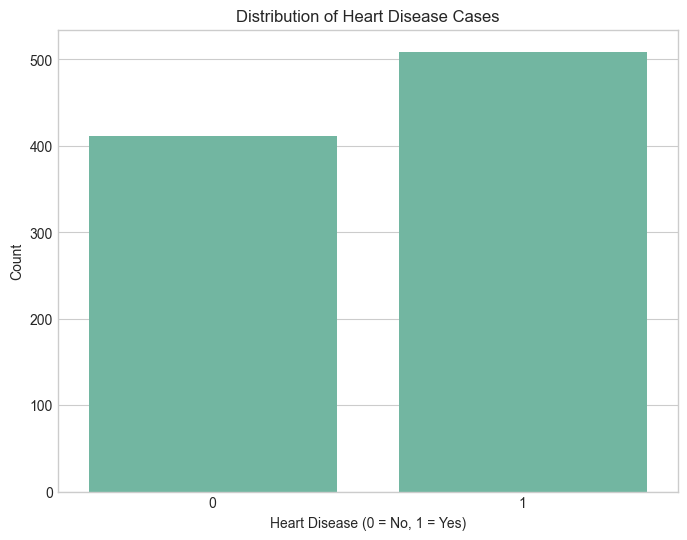

In [80]:
# Create a directory for saving figures if it doesn't exist
import os
if not os.path.exists('figures'):
    os.makedirs('figures')

# Distribution of target variable
plt.figure(figsize=(8, 6))
target_counts = df['num'].value_counts()
sns.countplot(x='num', data=df)
plt.title('Distribution of Heart Disease Cases')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.savefig('figures/knn_target_distribution.png')
print(f"Target distribution: No Disease: {target_counts[0]}, Disease: {target_counts[1]}")

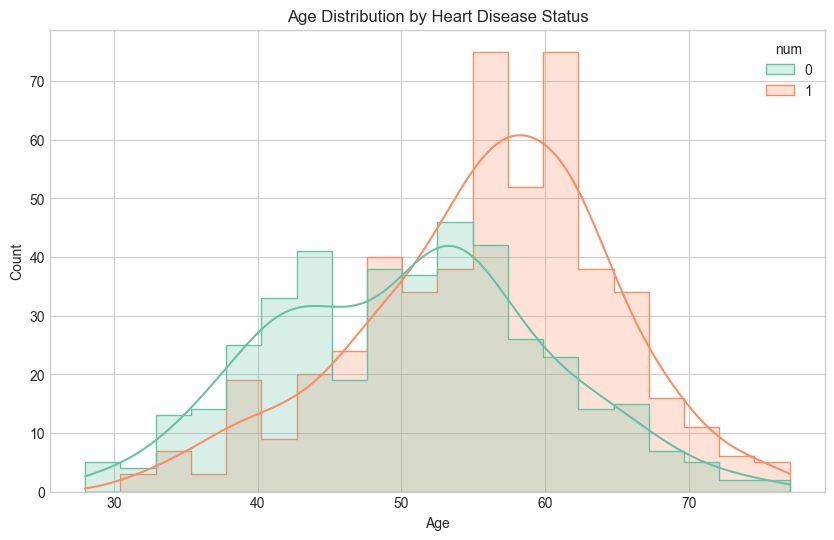

In [81]:
# Age distribution by heart disease status
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='num', element='step', kde=True, bins=20)
plt.title('Age Distribution by Heart Disease Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('figures/knn_age_distribution.png')

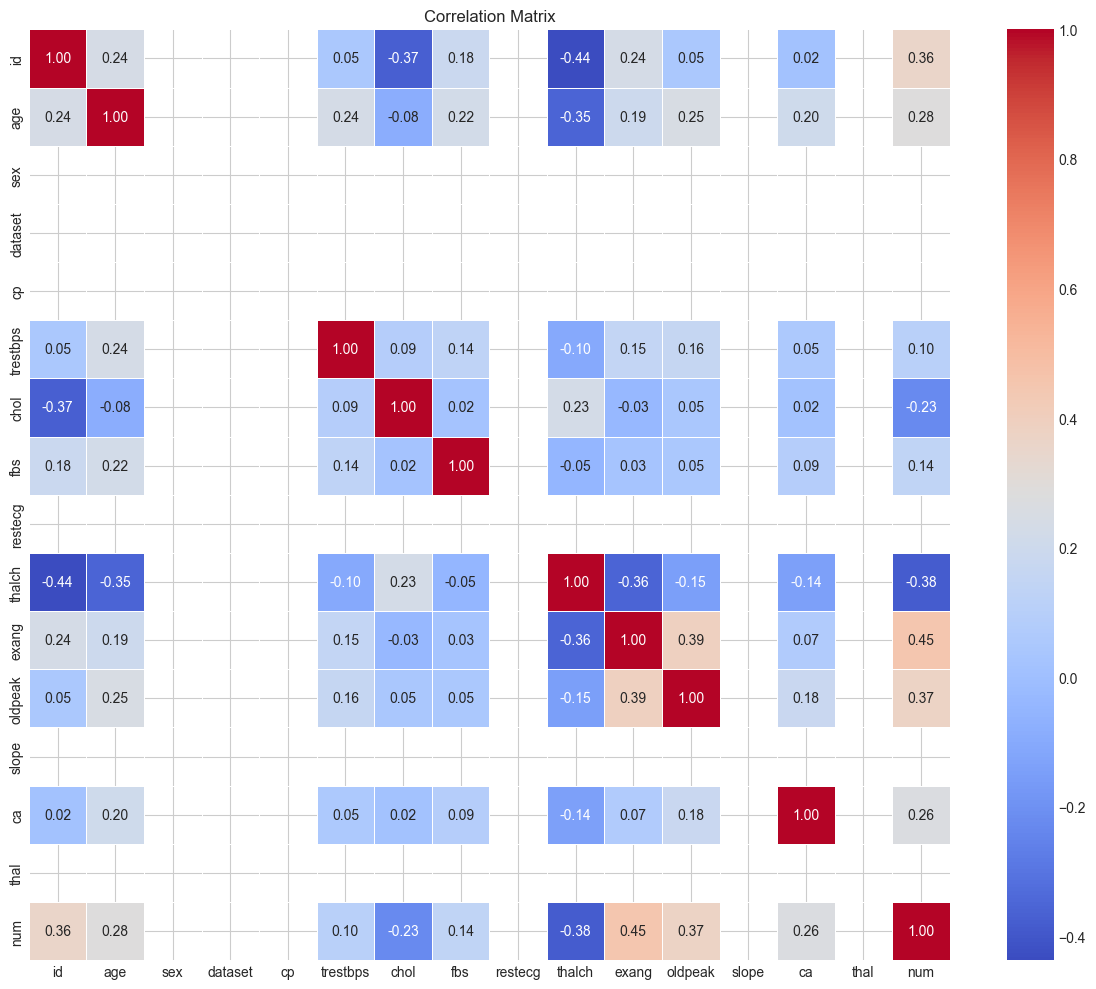

In [82]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('figures/knn_correlation_matrix.png')

In [83]:
# Data Preparation
print("\n--- Data Preparation ---")


--- Data Preparation ---


In [84]:
# Split features and target
X = df.drop('num', axis=1)
y = df['num']

In [85]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (736, 15)
Testing set shape: (184, 15)


In [86]:
# Model Development
print("\n--- KNN Model Development ---")


--- KNN Model Development ---


In [87]:
# Create a pipeline with scaling and KNN
knn_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [88]:
# Define hyperparameters to tune
param_grid = {
    'knn__n_neighbors': list(range(1, 31, 2)),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

In [89]:
# Use GridSearchCV to find optimal hyperparameters
print("Performing GridSearchCV to find optimal hyperparameters...")
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

Performing GridSearchCV to find optimal hyperparameters...


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
                         'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19,
                                              21, 23, 25, 27, 29],
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy')

In [90]:
# Get the best model
best_knn_model = grid_search.best_estimator_

In [91]:
# Model Evaluation
print("\n--- Model Evaluation ---")


--- Model Evaluation ---


In [92]:
# Make predictions
y_pred = best_knn_model.predict(X_test)
y_pred_proba = best_knn_model.predict_proba(X_test)[:, 1]

In [93]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8043


In [94]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        82
           1       0.82      0.82      0.82       102

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184



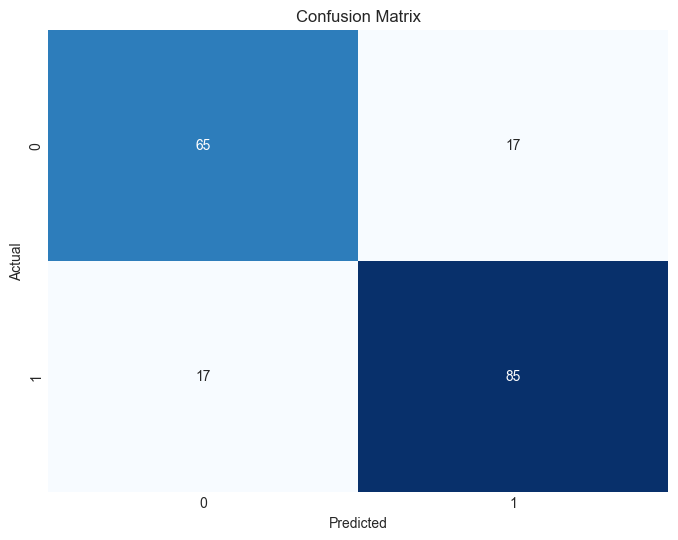

In [31]:
# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('figures/knn_confusion_matrix.png')

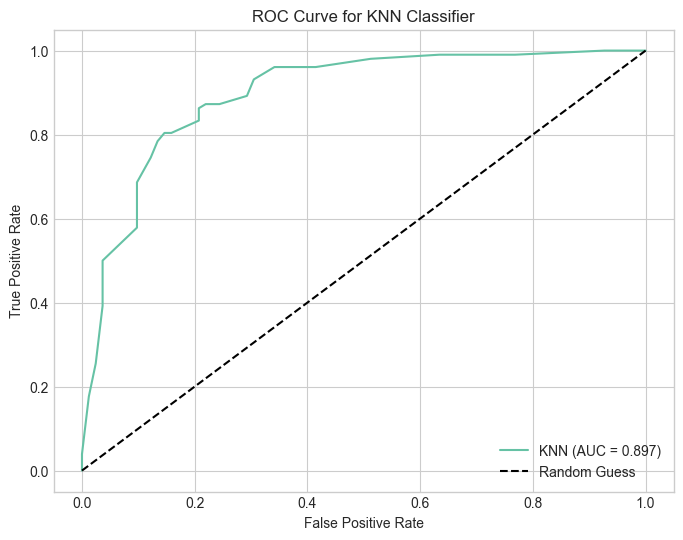

In [32]:
# ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN Classifier')
plt.legend(loc='lower right')
plt.savefig('figures/knn_roc_curve.png')


Visualizing the relationship between k value and model accuracy:


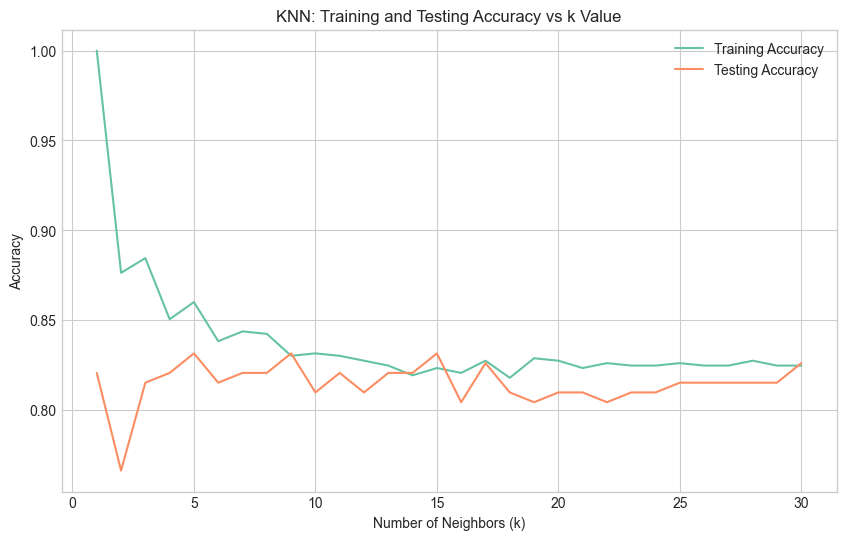

In [34]:
# Visualize k vs accuracy relationship
print("\nVisualizing the relationship between k value and model accuracy:")
k_values = list(range(1, 31))
train_accuracy = []
test_accuracy = []

for k in k_values:
    knn = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=k,
                                   weights=grid_search.best_params_['knn__weights'],
                                   metric=grid_search.best_params_['knn__metric']))
    ])
    knn.fit(X_train, y_train)
    
    # Calculate accuracies
    train_accuracy.append(knn.score(X_train, y_train))
    test_accuracy.append(knn.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracy, label='Training Accuracy')
plt.plot(k_values, test_accuracy, label='Testing Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN: Training and Testing Accuracy vs k Value')
plt.legend()
plt.grid(True)
plt.savefig('figures/knn_k_vs_accuracy.png')

In [35]:
# Feature importance analysis based on model coefficients
# For KNN, we'll use a different approach since it doesn't have direct feature importance
print("\nTop Features Analysis:")


Top Features Analysis:


     Feature  Importance
6       chol    0.061957
0         id    0.045109
10     exang    0.041304
11   oldpeak    0.009239
9     thalch    0.001087
2        sex    0.000000
3    dataset    0.000000
4         cp    0.000000
8    restecg    0.000000
12     slope    0.000000
14      thal    0.000000
5   trestbps   -0.001630
13        ca   -0.002717
7        fbs   -0.003804
1        age   -0.005978


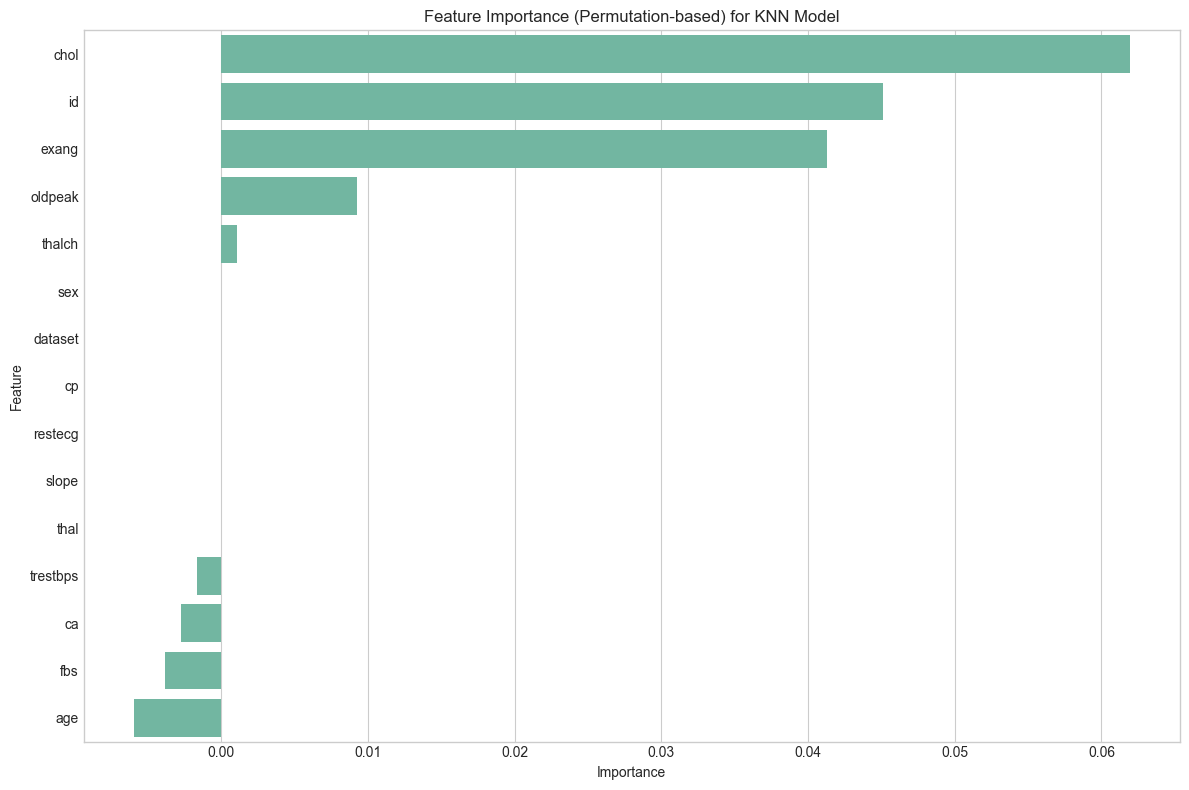

In [36]:
# Create a feature importance proxy using permutation importance
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_knn_model, X_test, y_test, n_repeats=10, random_state=42)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Permutation-based) for KNN Model')
plt.tight_layout()
plt.savefig('figures/knn_feature_importance.png')
print(feature_importance)

In [37]:
# Save the best model
import joblib
joblib.dump(best_knn_model, 'heart_disease_knn_model.pkl')
print("\nBest KNN model saved as 'heart_disease_knn_model.pkl'")
print("Figures saved in the 'figures' directory")


Best KNN model saved as 'heart_disease_knn_model.pkl'
Figures saved in the 'figures' directory
